## Image classification (single label)

Each image has one given label ("effusion", "normal")

Documentation:

Creating a dataset, training:
https://towardsdatascience.com/image-classification-using-fastai-v2-on-colab-33f3ebe9b5a3

Training, prediction + interpretation:
https://docs.fast.ai/tutorial.medical_imaging.html

In [31]:
# When I want to close any Google Colab project, before 
# I have to finish all the opened sessions 
# (go to Entorno de ejecucion > Gestionar sesiones)
# After finishing all the sesions I've to
# select None as execution environment 

# The next lines should be uncommented only when loading a new execution environment (GPU/TPU)
# NOTE: uncomment next lines when running this notebook on Drive
#from google.colab import drive
#drive.mount('/content/drive')


In [32]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [33]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0" # 0 = id of the gpu
# To know which id have to be set on the previous line, on Windows 10 run "nvidia-smi" on CMD to check all the installed GPUs data, like
# the id, driver version and CUDA version 

# Check if your GPU driver and CUDA is enabled and is accessible by PyTorch
# TO USE CUDA SELECT A GPU ON THE EXECUTION ENVIRONMENT, NOT A TPU
import torch; print(torch.version.cuda) # the CUDA version must be printed
print(torch.cuda.is_available()) # True must be printed (if False press on the Restart button at the top of the notebook)
print(torch.cuda.current_device()) # the id of the GPU must be printed

11.3
True
0


In [34]:
# Uncomment next line if "from fastai.vision.all import *" returns error
#!pip install fastai --upgrade # NOTE: uncomment on Drive 

from fastai.vision.all import *
from fastai.vision import *
from fastai.metrics import accuracy
#from torch.nn import L1Loss
from skimage.util import montage
import numpy as np

In [35]:
# Get the path of the dataset  

train_val_ds_path = ds_path = '../../../../Datasets/repoGit_ref/train_val' 

# dataset source - https://www.kaggle.com/epreis/rxtorax 

## Getting and converting the data

In [36]:
# Documentation for this cell 
# -> (DataBlock creation) https://docs.fast.ai/tutorial.datablock.html#Bounding-boxes
# -> (Split train/val data) https://docs.fast.ai/data.transforms.html#GrandparentSplitter

data = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # CategoryBlock = label
    get_items=get_image_files,
    get_y= parent_label, # parent_label = the folders names of the images are their labels (normal/effusion)
    splitter= GrandparentSplitter(), # split training/validation
    # validation images will be the ones that are stored inside "valid" folder of the dataset
    batch_tfms= [*aug_transforms(do_flip=False, size=(120,160)), Normalize.from_stats(*imagenet_stats)] 
)

In [37]:
path_dl = Path(train_val_ds_path)
Path.BASE_PATH = path_dl
path_dl.ls().sorted()

(#5) [Path('learned_effusion_classif_cossos_resnet50_export.pkl'),Path('learned_effusion_classif_imatgesSenceres_resnet50_v2_export.pkl'),Path('models'),Path('train'),Path('valid')]

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


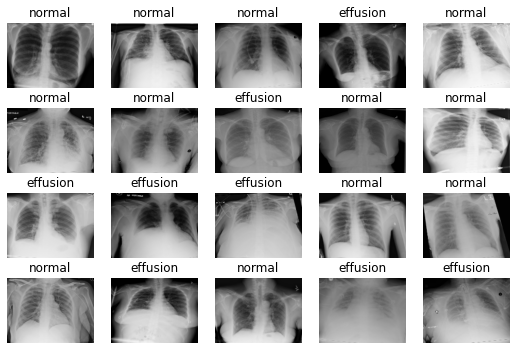

In [38]:
# Load the data and show a batch # NOTE: research to explain more properly what the 2 next lines do 

dls = data.dataloaders(path_dl, path=path_dl, bs = 64) # bs: how many samples per batch to load 
# If your GPU doesn't have enough memory and you can't run the whole notebook, 
# reduce the bs parameter value to, for example, 16 or 8
# and press the Restart button at the top of the notebook to empty the used memory

dls.show_batch(max_n=20, figsize=(9,6)) # NOTE: what do the values of figsize represent?
# NOTE: The batch shown contains validation and training images?

In [39]:
# Checks the labels using vocab

dls.vocab

['effusion', 'normal']

## Load learned model



In [40]:
# Create a CNN learner using resnet50
# Which architecture should we use?: 
# Check: https://theaisummer.com/cnn-architectures/
# According to the previous doc, a priori resnet50 presents higher accuracy than e.g. resnet34, resnet18
# resnet50 has more parameters than resnet34 and restnet18
# More parameters needs more computing power and memory during training


# A Leaner is a trainer for model using data (dls) to minimize the loss
learn = cnn_learner(dls, resnet50, metrics=accuracy)

learn.load('learned_effusion_classif_cossos_resnet50')


In [41]:
learn.model

# There are layer groups in any model architecture
# The initial layers are mostly used for understanding low-level features like 
# curves, lines, shapes, patterns. 
# When we use pre-trained models they are trained for identifying these features 
# on a large dataset of images like Imagenet(1000 categories).

# The later layers are mainly for capturing high-level features on current dataset like pets.
# These are fully connected layers which identify features like the shape of a dog or cat in its entirety.
# These layers hold composite or aggregated information from previous layers related to our current data.
# We improve information captured by these layers by training the model and optimizing loss based on target labels.( (i.e. requires_grad=True ).)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

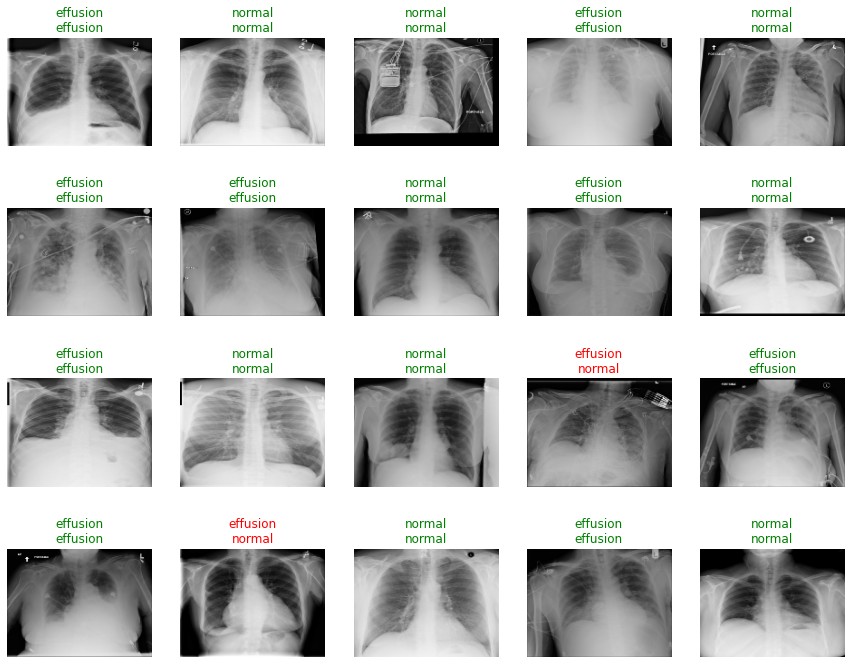

In [42]:
learn.show_results(max_n=20)

## Inference 

In [43]:
# Get the test set path
test_path = "../../../../Datasets/repoGit_ref/test/"
test_files = get_image_files(test_path)

# Add test dataloader to the learned model 
test_dl = learn.dls.test_dl(test_files, with_labels=True)

# Get the test_loss and the accuracy 
learn.validate(dl=test_dl)


(#2) [1.2644697427749634,0.8100000023841858]

## Interpretation (on test set)

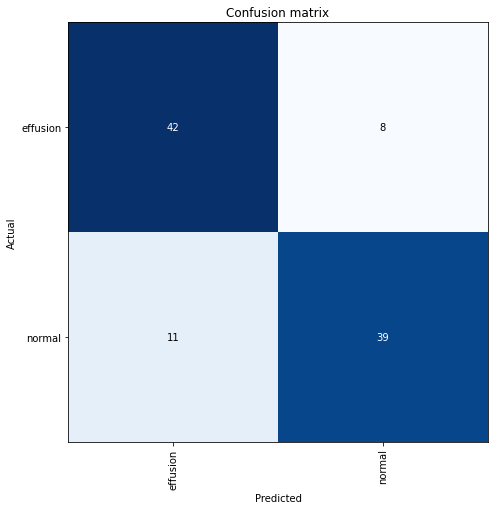

In [44]:
# Plot a confusion matrix 

interp = ClassificationInterpretation.from_learner(learn, dl=test_dl)
interp.plot_confusion_matrix(figsize=(7,7))

In [45]:
# Get the sensitivity (Sensitivity = True Positive/(True Positive + False Negative))

upp, low = interp.confusion_matrix()
tn, fp = upp[0], upp[1] # tn = True Negative; fp = False Positive 
fn, tp = low[0], low[1] # fn = False Negative; tp = True Positive

sensitivity = tp/(tp + fn)
print("Sensitivity: ", sensitivity)
# For example, if sensitivity is equal to 40% it means the model is only capable of correctly detecting 40% True Positives
# (i.e. who are labeled as Normal) but will miss 60% of False Negatives (patients that actually have Effusion but were told they did not! Not a good situation to be in).

Sensitivity:  0.78


In [46]:
# Compute specificity

specificity = tn/(fp + tn)
print("Specificity: ", specificity)

# For example, if the model has a specificity of 63% and hence can correctly detect 63% of the time 
# that a patient does not have Effusion but will incorrectly classify that 37% of the patients have Effusion (False Postive) but actually do not.

Specificity:  0.84


In [47]:
# Positive Predictive Value (PPV), between 0 and 1

ppv = tp/(tp+fp)
print("Positive Predictive Value: ", ppv)
# If ppv is low it means the model doesn't perform well in correctly predicting patients with Effusion
# If ppv is high it means the model predicts well the patients with Effusion

Positive Predictive Value:  0.8297872340425532


In [48]:
# Negative Predictive Value (NPV)

npv = tn/(tn+fn)
print("Negative Predictive Value: ", npv)

# If npv is low it means the model doesn't perform well in correctly predicting patients which don't have Effusion
# If npv is high it means the model predicts well the patients with Effusion

Negative Predictive Value:  0.7924528301886793
